# Usage consistensy analysis 
* Frequency trends 
* Frequent itemsets 
* Retention analysis

### 1. Analyzing Check-In Data Over Time (Trends by Month, Age, and Gender)

#### 1.1 Load and explore data 

In [274]:
import pandas as pd 
import matplotlib.pyplot as plt

# Load data
checkin_data = pd.read_csv("../data/checkins.csv", parse_dates= ['checkin_time', 'checkout_time'])
user_data = pd.read_csv("../data/_raw/users_data.csv")

# Merge user data and checkin data and drop irrelevant columns 
data = user_data.merge(checkin_data, on="user_id", how="left")
data = data.drop(columns= ["first_name", "last_name","birthdate", "calories_burned"])

# Extract month from checkin time 
data['month'] = data['checkin_time'].dt.month 

bins = [0, 18, 25, 35, 50, 65, 100]
labels = ['<18', '18-25', '26-35', '36-50', '51-65', '65+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Group data by month, gender, and age group
monthly_trends = data.groupby(['month', 'gender', 'age_group']).size().reset_index(name='check_in_count')

print(monthly_trends.head(10))



   month  gender age_group  check_in_count
0      1  Female       <18               0
1      1  Female     18-25            2030
2      1  Female     26-35            3092
3      1  Female     36-50            4330
4      1  Female     51-65            4595
5      1  Female       65+               0
6      1    Male       <18               0
7      1    Male     18-25            2284
8      1    Male     26-35            3146
9      1    Male     36-50            5073


/var/folders/5_/qzm0v30543z41kg2f8py6jqh0000gn/T/ipykernel_92096/563956364.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_trends = data.groupby(['month', 'gender', 'age_group']).size().reset_index(name='check_in_count')


#### 1.2 Visualize data

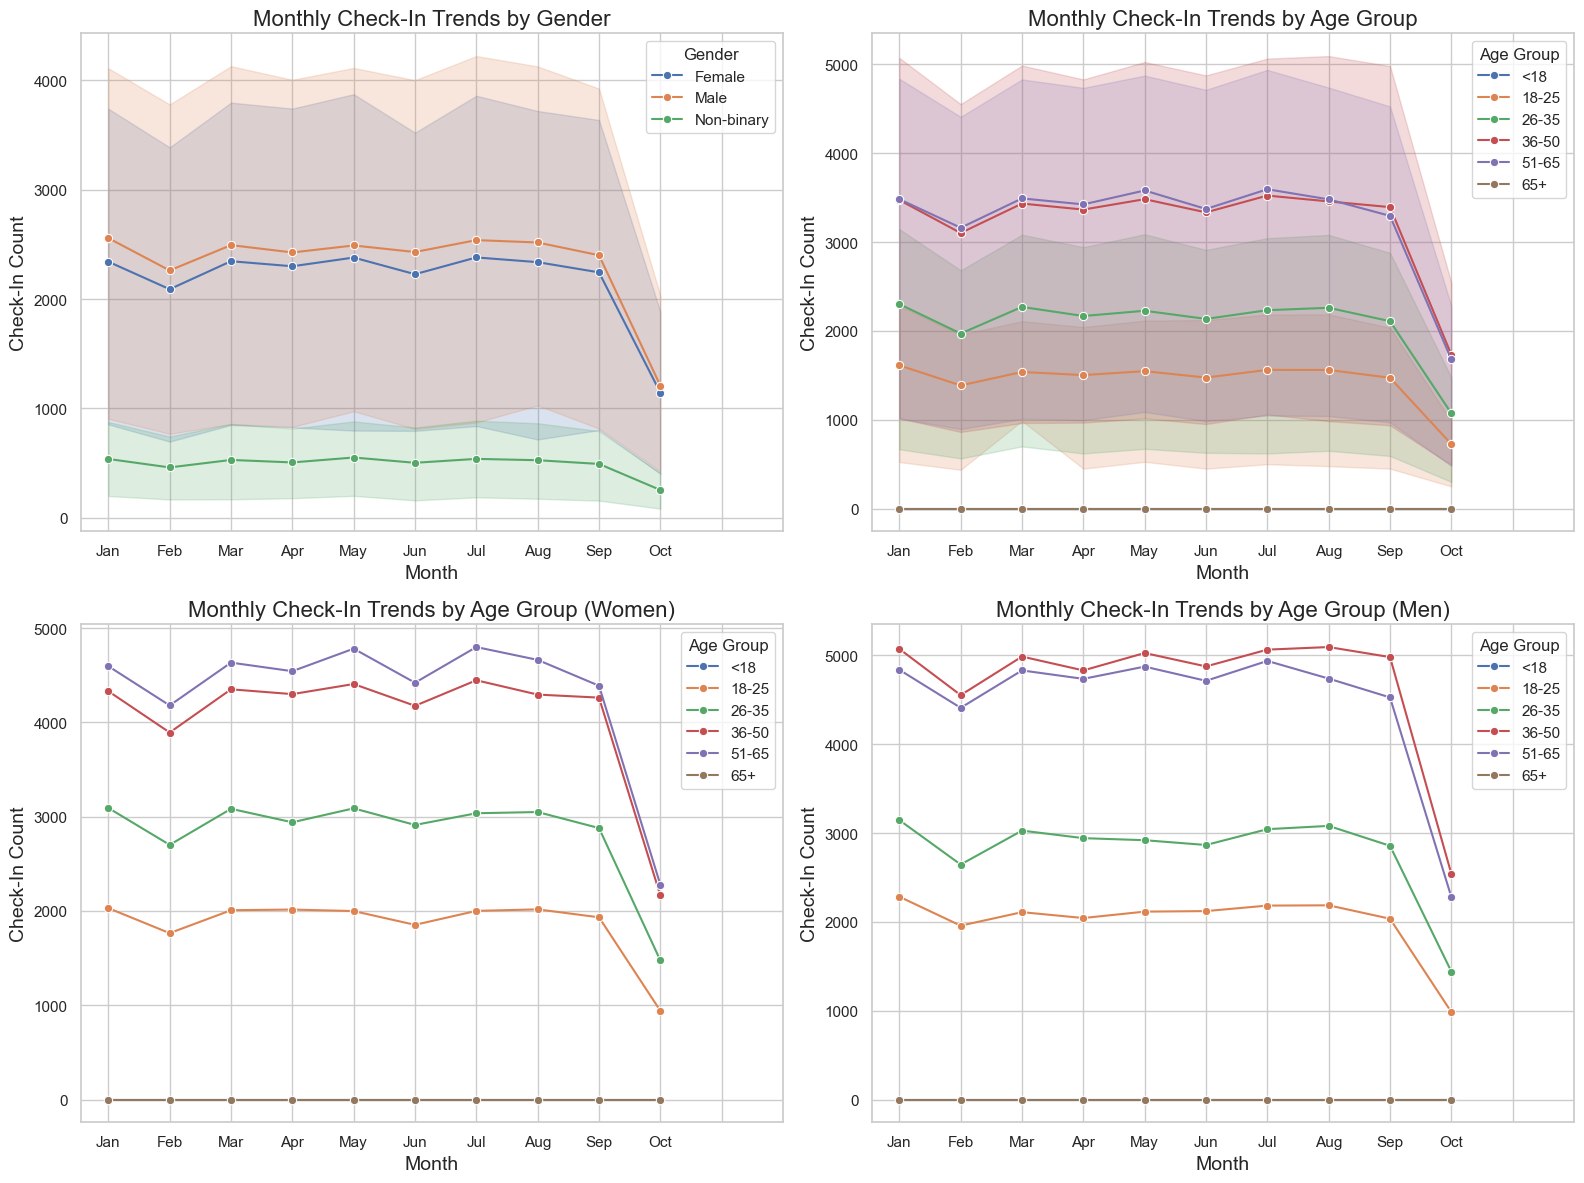

In [275]:
import seaborn as sns


fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Monthly Check-In Trends by Gender
sns.lineplot(data=monthly_trends, x='month', y='check_in_count', hue='gender', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Monthly Check-In Trends by Gender', fontsize=16)
axes[0, 0].set_xlabel('Month', fontsize=14)
axes[0, 0].set_ylabel('Check-In Count', fontsize=14)
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[0, 0].legend(title='Gender')

# Plot 2: Monthly Check-In Trends by Age Group
sns.lineplot(data=monthly_trends, x='month', y='check_in_count', hue='age_group', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('Monthly Check-In Trends by Age Group', fontsize=16)
axes[0, 1].set_xlabel('Month', fontsize=14)
axes[0, 1].set_ylabel('Check-In Count', fontsize=14)
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[0, 1].legend(title='Age Group')

# Plot 3: Monthly Check-in data for women by Age group
women_data = monthly_trends[monthly_trends['gender'] == 'Female']
sns.lineplot(data=women_data, x='month', y='check_in_count', hue='age_group', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Monthly Check-In Trends by Age Group (Women)', fontsize=16)
axes[1, 0].set_xlabel('Month', fontsize=14)
axes[1, 0].set_ylabel('Check-In Count', fontsize=14)
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[1, 0].legend(title='Age Group')

# Plot 4: Monthly Check-in data for men by Age group
men_data = monthly_trends[monthly_trends['gender'] == 'Male']
sns.lineplot(data=men_data, x='month', y='check_in_count', hue='age_group', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('Monthly Check-In Trends by Age Group (Men)', fontsize=16)
axes[1, 1].set_xlabel('Month', fontsize=14)
axes[1, 1].set_ylabel('Check-In Count', fontsize=14)
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[1, 1].legend(title='Age Group')


plt.tight_layout()
plt.show()


### 2. Frequent itemset mining: Frequent patterns (Cross-combination of checkin time and day of the week)

#### 2.1 Loading and preprocessing data 

In [276]:

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Extract day of week and time of day
data['day_of_week'] = data['checkin_time'].dt.day_name()

# Group check-ins into user-level transactions
transactions = data[['day_of_week', 'time_of_day']].apply(
    lambda x: [x['day_of_week'], x['time_of_day']], axis=1
).tolist()

print(f"Number of transactions: {len(transactions)}")
print(f"Number of unique items: {len(set(item for sublist in transactions for item in sublist))}")


Number of transactions: 300000
Number of unique items: 10


#### 2.2 Applying the A-priori algorithm to find frequent itemsets


In [277]:

encoder = TransactionEncoder()
encoded_data = encoder.fit(transactions).transform(transactions)
df = pd.DataFrame(encoded_data, columns=encoder.columns_)

# Find frequent itemsets
# using a fairly low min_support as if it was higher the itemset of lenght 2 would not be considered 

frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True, max_len =2)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

print("Frequent Itemsets:")
print(frequent_itemsets)
print(rules)

Frequent Itemsets:
     support              itemsets
0   0.141893              (Friday)
1   0.141933              (Monday)
2   0.142460            (Saturday)
3   0.146980              (Sunday)
4   0.141713            (Thursday)
5   0.142327             (Tuesday)
6   0.142693           (Wednesday)
7   0.334570           (afternoon)
8   0.265797             (evening)
9   0.399633             (morning)
10  0.056487     (morning, Friday)
11  0.056957     (morning, Monday)
12  0.056797   (Saturday, morning)
13  0.058733     (morning, Sunday)
14  0.056413   (Thursday, morning)
15  0.057380    (morning, Tuesday)
16  0.056867  (Wednesday, morning)
    antecedents  consequents  antecedent support  consequent support  \
0     (morning)     (Friday)            0.399633            0.141893   
1      (Friday)    (morning)            0.141893            0.399633   
2     (morning)     (Monday)            0.399633            0.141933   
3      (Monday)    (morning)            0.141933            0.3

#### 2.3 Visualize results

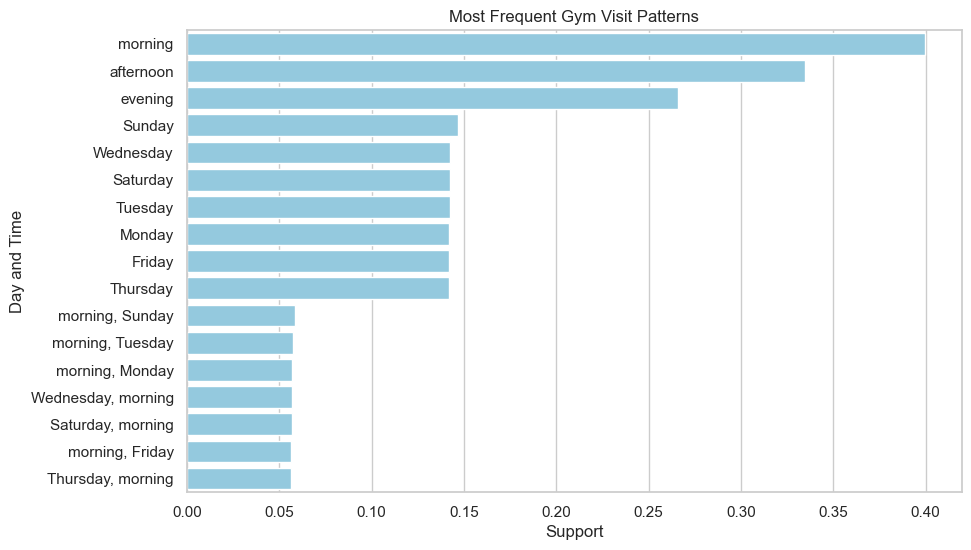

In [278]:
# Sort itemsets by support
top_patterns = frequent_itemsets.sort_values(by="support", ascending=False)
top_patterns['itemsets'] = top_patterns['itemsets'].apply(lambda x: ', '.join(list(x)))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="support", y=top_patterns["itemsets"].astype(str), data=top_patterns, color="skyblue")
plt.title("Most Frequent Gym Visit Patterns")
plt.xlabel("Support")
plt.ylabel("Day and Time")
plt.show()

### 2.4 Demographic segmentation of checkin-patterns (Gender)


#### 2.4.1 Finding frequent itemsets and generating association rules

In [279]:

female_data = data[data['gender'] == 'Female']
male_data = data[data['gender'] == 'Male']

# creating transactions for female users (based on day of the week and time of day)
female_transactions = female_data[['day_of_week', 'time_of_day']].apply(
    lambda x: [x['day_of_week'], x['time_of_day']], axis=1
).tolist()

# appluing A-Priori algorithm for female transactions
encoder = TransactionEncoder()
encoded_female_data = encoder.fit(female_transactions).transform(female_transactions)
df_female = pd.DataFrame(encoded_female_data, columns=encoder.columns_)

frequent_itemsets_female = apriori(df_female, min_support=0.05, use_colnames=True, max_len=2)

# creating association rules for female group
association_rules_female = association_rules(frequent_itemsets_female, metric="confidence", min_threshold=0.1)


# same process for male 

male_transactions = male_data[['day_of_week', 'time_of_day']].apply(
    lambda x: [x['day_of_week'], x['time_of_day']], axis=1
).tolist()

encoded_male_data = encoder.fit(male_transactions).transform(male_transactions)
df_male = pd.DataFrame(encoded_male_data, columns=encoder.columns_)

frequent_itemsets_male = apriori(df_male, min_support=0.05, use_colnames=True, max_len=2)

association_rules_male = association_rules(frequent_itemsets_male, metric="confidence", min_threshold=0.1)

print("Frequent Itemsets for Female:")
print(frequent_itemsets_female)

print("Association Rules for Female:")
print(association_rules_female)


print("Frequent Itemsets for Male:")
print(frequent_itemsets_male)

print("Association Rules for Male:")
print(association_rules_male)


Frequent Itemsets for Female:
     support              itemsets
0   0.141184              (Friday)
1   0.141620              (Monday)
2   0.143058            (Saturday)
3   0.147021              (Sunday)
4   0.141842            (Thursday)
5   0.142423             (Tuesday)
6   0.142852           (Wednesday)
7   0.335131           (afternoon)
8   0.264222             (evening)
9   0.400647             (morning)
10  0.055594     (morning, Friday)
11  0.056825     (morning, Monday)
12  0.057583   (Saturday, morning)
13  0.058860     (morning, Sunday)
14  0.056466   (Thursday, morning)
15  0.058088    (morning, Tuesday)
16  0.057231  (Wednesday, morning)
Association Rules for Female:
    antecedents  consequents  antecedent support  consequent support  \
0     (morning)     (Friday)            0.400647            0.141184   
1      (Friday)    (morning)            0.141184            0.400647   
2     (morning)     (Monday)            0.400647            0.141620   
3      (Monday)    (mo

#### 2.4.2 Visualize results

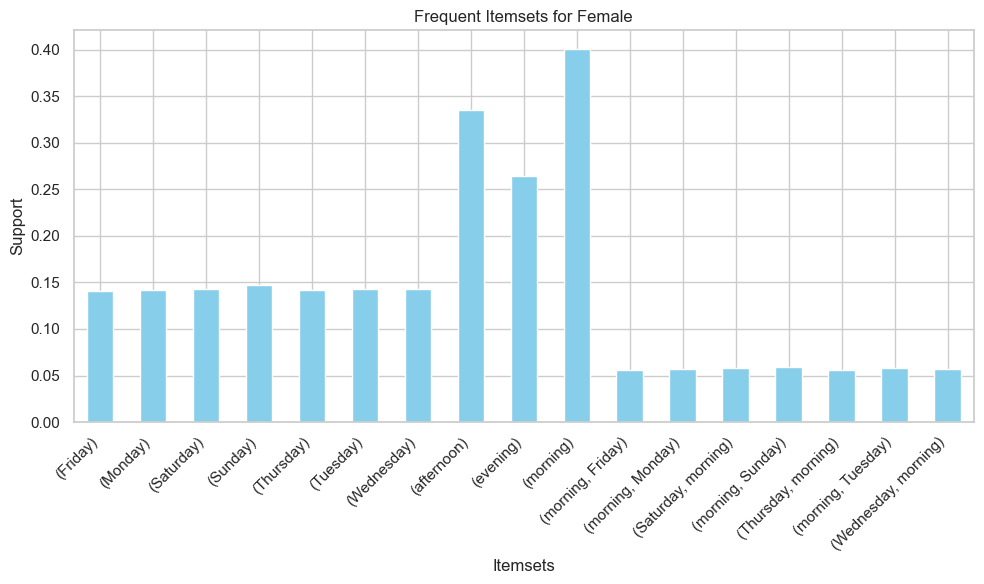

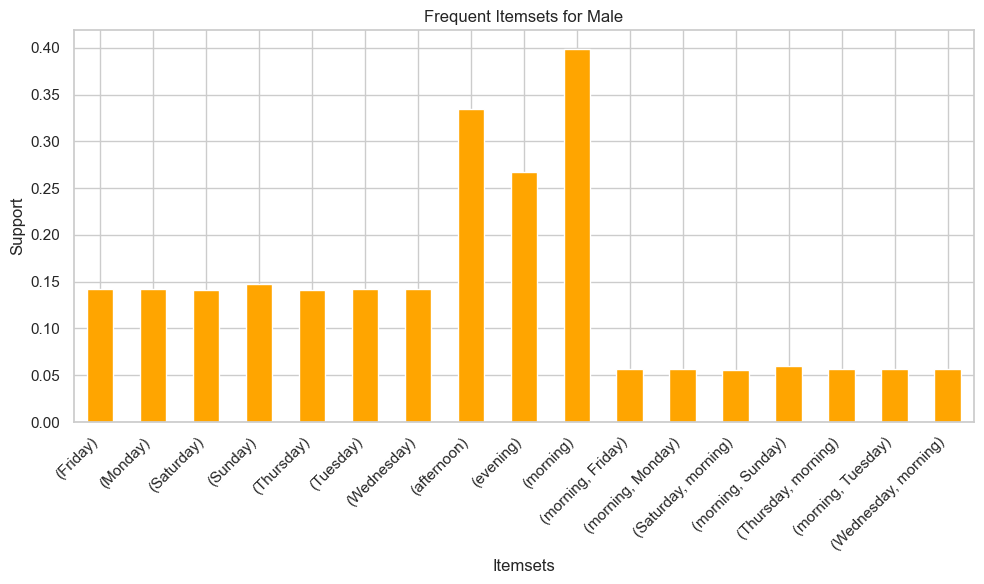

Association Rules for Female:


,antecedents,consequents,support,confidence,lift
0,(morning),(Friday),0.055594,0.138760,0.982831
1,(Friday),(morning),0.055594,0.393769,0.982831
2,(morning),(Monday),0.056825,0.141834,1.001513
3,(Monday),(morning),0.056825,0.401253,1.001513
4,(Saturday),(morning),0.057583,0.402513,1.004658
5,(morning),(Saturday),0.057583,0.143725,1.004658
6,(morning),(Sunday),0.058860,0.146913,0.999268
7,(Sunday),(morning),0.058860,0.400354,0.999268
8,(Thursday),(morning),0.056466,0.398091,0.993619
9,(morning),(Thursday),0.056466,0.140937,0.993619


Association Rules for Male:


,antecedents,consequents,support,confidence,lift
0,(morning),(Friday),0.056691,0.142230,1.001325
1,(Friday),(morning),0.056691,0.399114,1.001325
2,(morning),(Monday),0.056934,0.142839,1.001786
3,(Monday),(morning),0.056934,0.399298,1.001786
4,(Saturday),(morning),0.055526,0.393586,0.987456
5,(morning),(Saturday),0.055526,0.139307,0.987456
6,(morning),(Sunday),0.059521,0.149330,1.008828
7,(Sunday),(morning),0.059521,0.402105,1.008828
8,(Thursday),(morning),0.056369,0.398595,1.000022
9,(morning),(Thursday),0.056369,0.141423,1.000022


In [280]:

# Plot for female
frequent_itemsets_female.plot(kind='bar', x='itemsets', y='support', legend=False, figsize=(10, 6), color='skyblue')
plt.title('Frequent Itemsets for Female')
plt.xlabel('Itemsets')
plt.ylabel('Support')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot for male 
frequent_itemsets_male.plot(kind='bar', x='itemsets', y='support', legend=False, figsize=(10, 6), color='orange')
plt.title('Frequent Itemsets for Male')
plt.xlabel('Itemsets')
plt.ylabel('Support')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# association rules female
print("Association Rules for Female:")
display(association_rules_female[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# association rules male 
print("Association Rules for Male:")
display(association_rules_male[['antecedents', 'consequents', 'support', 'confidence', 'lift']])




### 2.5 Demographic segmentation of checkin-patterns (Age)


#### 2.5.1 Finding frequent itemsets and generating association rules

In [281]:

# creating age groups 
bins = [0, 18, 25, 35, 50, 65, 100]
labels = ['<18', '18-25', '26-35', '36-50', '51-65', '65+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

frequent_itemsets_dict = {}
association_rules_dict = {}

# Looping through each age group and doing the same process as done for gender before 
for age_group in labels:
    age_group_data = data[data['age_group'] == age_group]
    if age_group_data.empty:
        continue  

    # creating transactions for this age group (based on day of the week and time of day)
    transactions = age_group_data[['day_of_week', 'time_of_day']].apply(
        lambda x: [x['day_of_week'], x['time_of_day']], axis=1
    ).tolist()

    # applying A-Priori for the transactions in this age group
    encoder = TransactionEncoder()
    encoded_data = encoder.fit(transactions).transform(transactions)
    df = pd.DataFrame(encoded_data, columns=encoder.columns_)

    frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True, max_len=2)

    association_rules_age_group = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

    # i am using this to store the result 
    frequent_itemsets_dict[age_group] = frequent_itemsets
    association_rules_dict[age_group] = association_rules_age_group

    # printed for insights in the data before visualizing it 
    print(f"Frequent Itemsets for Age Group {age_group}:")
    print(frequent_itemsets)
    
    print(f"Association Rules for Age Group {age_group}:")
    print(association_rules_age_group)


Frequent Itemsets for Age Group 18-25:
     support              itemsets
0   0.142357              (Friday)
1   0.142149              (Monday)
2   0.141639            (Saturday)
3   0.150769              (Sunday)
4   0.139970            (Thursday)
5   0.141755             (Tuesday)
6   0.141361           (Wednesday)
7   0.332314           (afternoon)
8   0.266222             (evening)
9   0.401465             (morning)
10  0.055756     (morning, Friday)
11  0.057471     (morning, Monday)
12  0.057448   (Saturday, morning)
13  0.051353   (afternoon, Sunday)
14  0.059974     (morning, Sunday)
15  0.056521   (Thursday, morning)
16  0.056822    (morning, Tuesday)
17  0.057471  (Wednesday, morning)
Association Rules for Age Group 18-25:
    antecedents  consequents  antecedent support  consequent support  \
0     (morning)     (Friday)            0.401465            0.142357   
1      (Friday)    (morning)            0.142357            0.401465   
2     (morning)     (Monday)            0

#### 2.5.2 Visualize results

<Figure size 1000x600 with 0 Axes>

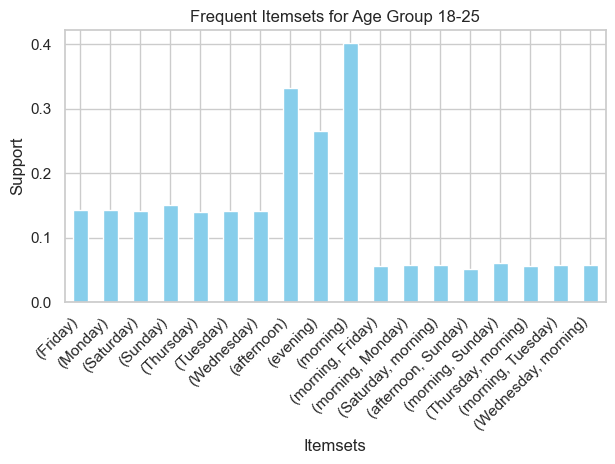

<Figure size 1000x600 with 0 Axes>

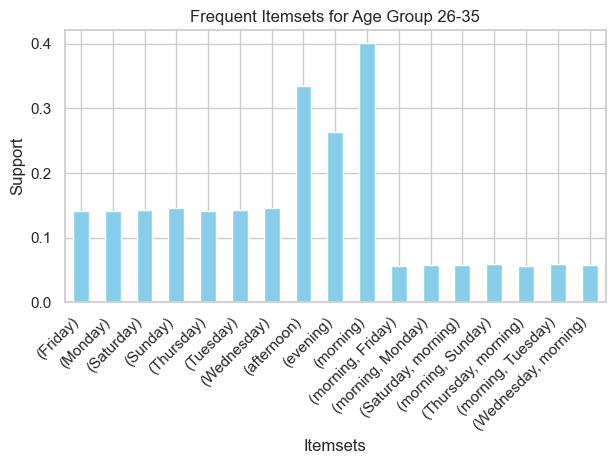

<Figure size 1000x600 with 0 Axes>

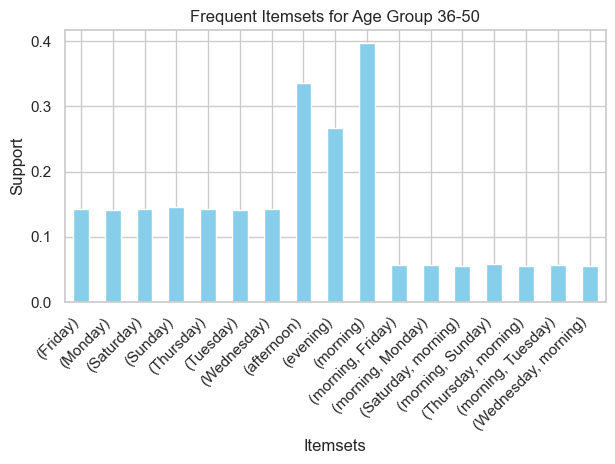

<Figure size 1000x600 with 0 Axes>

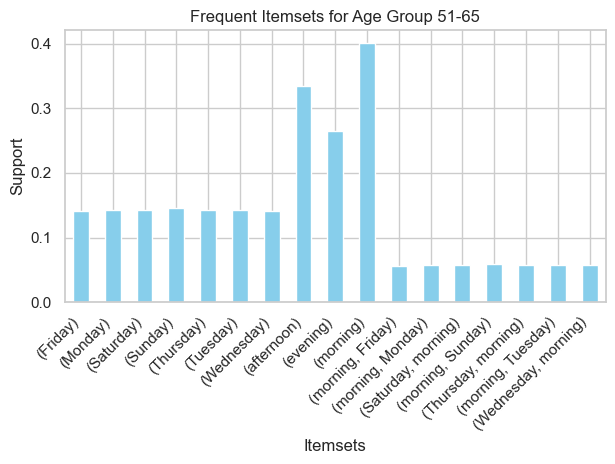

In [282]:
# for every agegroup I want to make a plot

for age_group in labels:
    # skipping if no frequent itemsets or rules were found
    if age_group not in frequent_itemsets_dict or frequent_itemsets_dict[age_group].empty:
        continue
    
    plt.figure(figsize=(10, 6))
    frequent_itemsets = frequent_itemsets_dict[age_group]
    frequent_itemsets.plot(kind='bar', x='itemsets', y='support', legend=False, color='skyblue')
    plt.title(f'Frequent Itemsets for Age Group {age_group}')
    plt.xlabel('Itemsets')
    plt.ylabel('Support')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


### 3 User Retention Analysis by Demographics, Subscription Plan, and Sign-Up date"



#### 3.1 Calculate retention and demographic segmentation

In [283]:

# finding the first check-in time per user, and then calculating the time since the user's first check in 
data['first_checkin_time'] = data.groupby('user_id')['checkin_time'].transform('min')

data['days_since_first_checkin'] = (data['checkin_time'] - data['first_checkin_time']).dt.days
retention_window = 30
data['retention_status'] = data['days_since_first_checkin'].apply(lambda x: 'Retained' if x > retention_window else 'Dropped off')

bins = [0, 18, 25, 35, 50, 65, 100]
labels = ['<18', '18-25', '26-35', '36-50', '51-65', '65+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

retention_by_age = data.groupby('age_group')['retention_status'].value_counts(normalize=True).unstack(fill_value=0)

retention_by_gender = data.groupby('gender')['retention_status'].value_counts(normalize=True).unstack(fill_value=0)

retention_by_plan = data.groupby('subscription_plan')['retention_status'].value_counts(normalize=True).unstack(fill_value=0)

data['sign_up_month'] = pd.to_datetime(data['sign_up_date']).dt.to_period('M')

cohort_retention = data.groupby(['sign_up_month', 'retention_status']).size().unstack(fill_value=0)

cohort_retention_percent = cohort_retention.div(cohort_retention.sum(axis=1), axis=0)


/var/folders/5_/qzm0v30543z41kg2f8py6jqh0000gn/T/ipykernel_92096/1729630143.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_by_age = data.groupby('age_group')['retention_status'].value_counts(normalize=True).unstack(fill_value=0)


#### 3.2 Visualize results

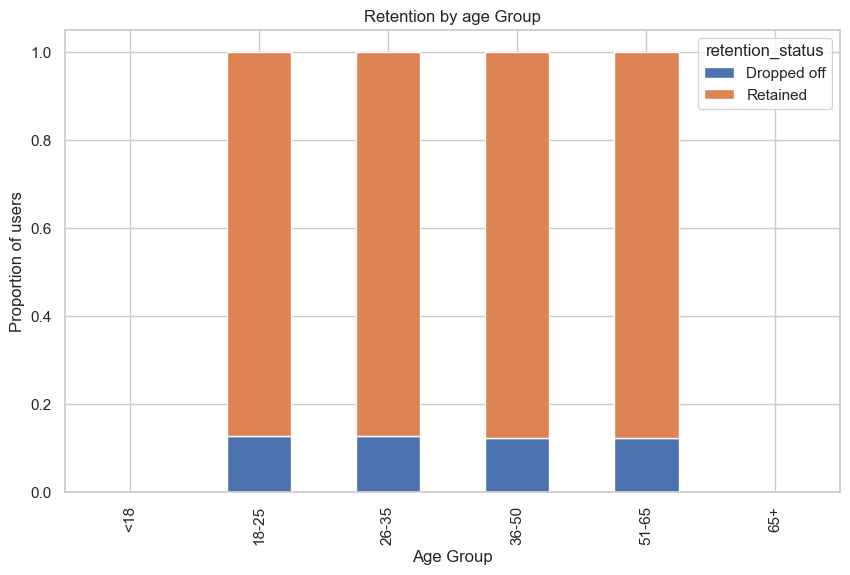

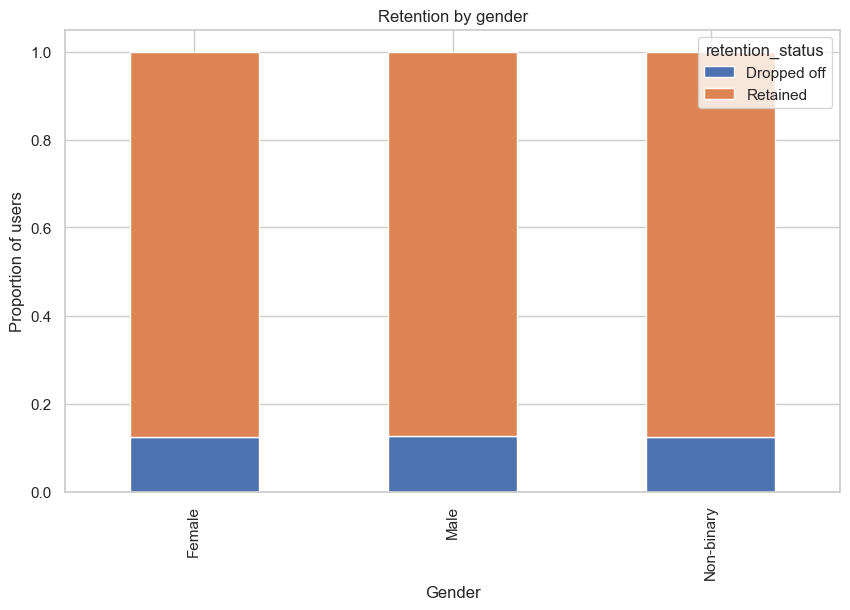

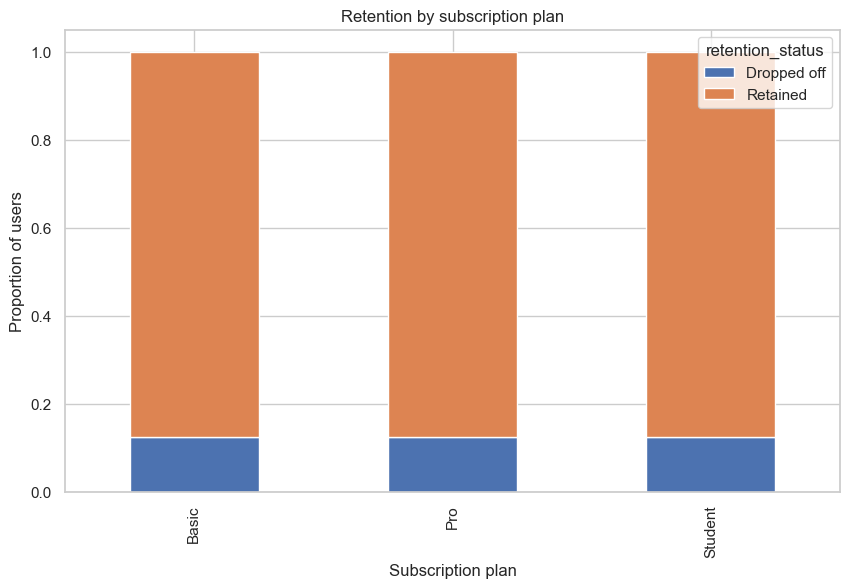

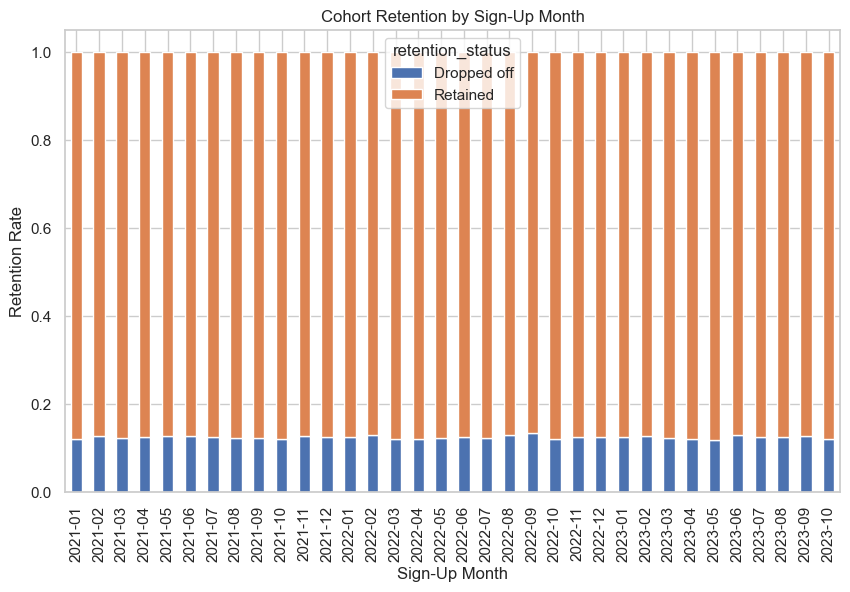

In [284]:
# Plot retention by age
retention_by_age.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Retention by age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion of users')
plt.show()

# Plot retention by gender
retention_by_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Retention by gender')
plt.xlabel('Gender')
plt.ylabel('Proportion of users')
plt.show()


# Plot retention by subscription plan
retention_by_plan.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Retention by subscription plan')
plt.xlabel('Subscription plan')
plt.ylabel('Proportion of users')
plt.show()

# Plot cohort retention
cohort_retention_percent.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Cohort Retention by Sign-Up Month')
plt.xlabel('Sign-Up Month')
plt.ylabel('Retention Rate')
plt.show()

